<a href="https://colab.research.google.com/github/rbondili/POC_Speech_Recognition/blob/master/Speaker_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center><font size=5>Speech Recognition</font></h1>

## Table of contents

- [Objective](#obj)
- [Data](#data)
- [Data Preprocessing](#data_preproc)
- [Time Domain Model](#time_model)
- [Time-Frequency Domain Model](#time_freq_model)

## Objective <a id='obj'></a>

![alt text](https://)In this notebook, we will learn how to deal with audio/voice singals. Accordingly, we will build time domain and time-frequency domain models for the purpose of speech classification.

## Data <a id='data'></a>

Let us consider the Free Spoken Digit Dataset (FSDD), so called "speech MNIST" dataset. The dataset contains a set of recorded spoken digits in wav formats. You can access to this dataset in the following URL: https://github.com/Jakobovski/free-spoken-digit-dataset

&#x270d; Download the dataset

This can be directly download to your google drive without downloading locally and then uploading

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My\ Drive/Colab\ Notebooks/SpeechRecognition/

/content/drive/My Drive/Colab Notebooks/SpeechRecognition


In [0]:
!rm -rf free-spoken-digit-dataset-master master.zip
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/master.zip
!unzip -q -o master.zip
!rm master.zip

--2020-06-08 19:02:25--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/master [following]
--2020-06-08 19:02:25--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [     <=>            ]   9.03M  10.3MB/s    in 0.9s    

2020-06-08 19:02:26 (10.3 MB/s) - ‘master.zip’ saved [9465583]



In [0]:
!git colab 'https://github.com/Jakobovski/free-spoken-digit-dataset.git'

git: 'colab' is not a git command. See 'git --help'.

The most similar command is
	clone


In [0]:
ls

free-spoken-digit-dataset-master/


&#x270d; LibROSA is a python package for music and audio analysis

 Load an audio file using librosa.load. To preserve the native sampling rate of the file, **use `sr=None`.**



In [0]:
!pip install librosa

In [0]:
import os
import librosa # !pip install librosa

audio_path = os.path.join(
    os.getcwd(),
    '/content/drive/My Drive/Colab Notebooks/SpeechRecognition/free-spoken-digit-dataset-master/recordings'
)

audio_files = os.listdir(audio_path)

sample_audio_path = os.path.join(audio_path, audio_files[100])

X, sr = librosa.load(sample_audio_path, sr=None)

&#x270d; Display the length of the audio array and sampling rate.

In [0]:
print('Audio signal shape:',  X.shape)
print('Sampling rate: {} Hz'.format(sr))

Audio signal shape: (4108,)
Sampling rate: 8000 Hz


&#x270d; How long is the audio signal in seconds?
<br>
understanding what is sr

In [0]:
print('Audio length: {} seconds'.format(X.shape[0] / sr ))

Audio length: 0.5135 seconds


&#x270d; Play your chosen audio file and play the record

In [0]:
from IPython.display import Audio

Audio(X, rate=sr)

&#x270d; Plot the audio signal in time domain.

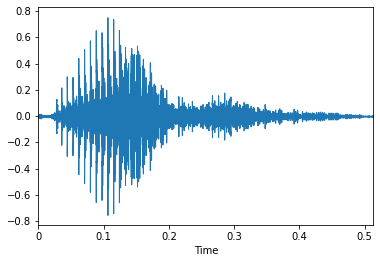

In [0]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

librosa.display.waveplot(X, sr)

&#x270d; Display the audio signal's spectrogram on a logarithmic scale using *librosa.stft*. Note that, the Short-Time Fourier Transform (STFT) represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.


Decibel:
https://en.wikipedia.org/wiki/Decibel#Acoustics



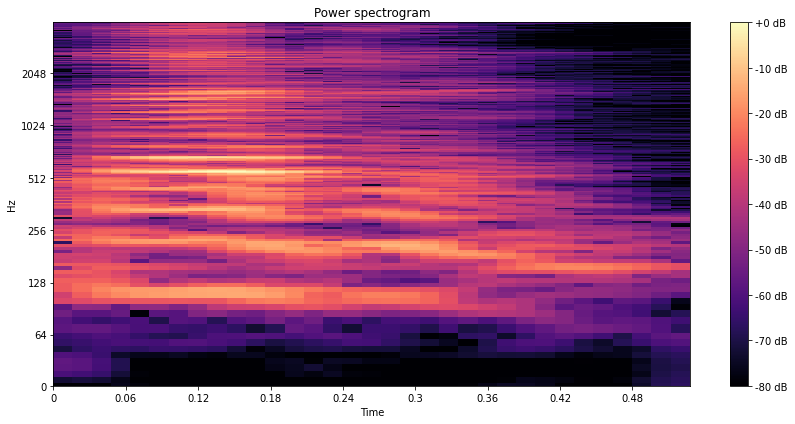

In [0]:
import numpy as np

n_fft = 1024
hop_length = 128

stft = librosa.stft(X, n_fft=n_fft, hop_length=hop_length)

stft_magnitude, stft_phase = librosa.magphase(stft)

stft_magnitude_dB = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))

librosa.display.specshow(stft_magnitude_dB, 
                         x_axis = 'time',
                         y_axis = 'log',
                         sr = sr,
                         hop_length = hop_length)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

&#x270d; What is the hop length in seconds?

In [0]:
print('Hop length: {} seconds'.format(hop_length/sr)) 

Hop length: 0.016 seconds


## Data Preprocessing <a id='data_preproc'></a>

&#x270d; Find all audio files duration in seconds and sampling rate, and plot their distributions.

In [0]:
audio_path = os.path.join(os.getcwd(), '/content/drive/My Drive/Colab Notebooks/SpeechRecognition/free-spoken-digit-dataset-master/recordings')
audio_files = os.listdir(audio_path)

all_audios_sr = []
all_audios_duration = []

for audio_file in audio_files:
  audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
  all_audios_sr.append(sr)
  all_audios_duration.append(len(audio) / sr)

all_audios_duration = np.asarray(all_audios_duration)
all_audios_sr = np.asarray(all_audios_sr)


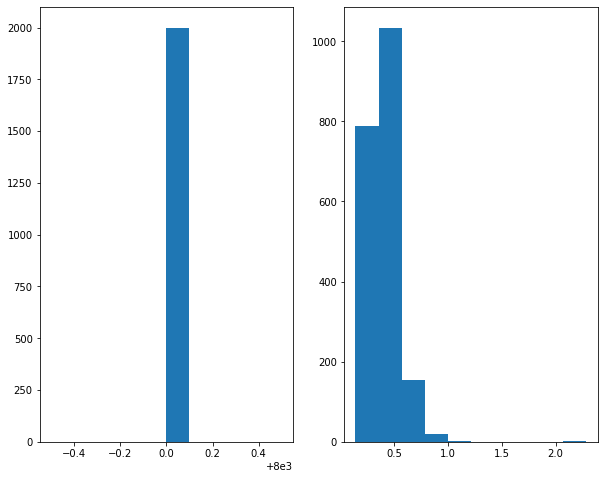

In [0]:
plt.figure(figsize = (10, 8))
plt.subplot(1,2,1)
plt.hist(all_audios_sr);

plt.subplot(1,2,2)
plt.hist(all_audios_duration);

&#x270d; Clip or pad audio signals to have one second duration for all audios. Extract audio labels as well. Keep audio signals from speaker 'jackson' for test set, and the rest speakers for training.

Dataformat Number_NAME_recordnumber.wav

In [0]:
audio_duration_sec = 1

def padOrClip(a, n):
  # Clip
  if a.shape[0] > n:
    return(a[:n])
  
  #padding
  else:
    return np.hstack(( a, np.zeros( n - a.shape[0])))

&#x270d; Build a model based on time domain input signals and evaluate the classification performance of it. 

## Time Domain Model <a id='time_model'></a>

&#x270d; Now, create a model based on time-frequency domain input signals and evaluate its performance.

abs(the output from stft) gives you the frequency domain

In [0]:
Xtime, ytime = [], []

for audio_file in audio_files:
    
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    
    X1 = padOrClip(audio, int(audio_duration_sec*sr))
    # spectrogram = np.abs(librosa.stft(X1))

    digit = audio_file.split('_')[0]
    label = audio_file.split('_')[1]
    
    Xtime.append(X1)
    ytime.append(label)
    
Xtime = np.asarray(Xtime)
ytime = np.asarray(ytime)

In [0]:
from sklearn.model_selection import train_test_split
X_time_train, X_time_test, y_time_trn_label, y_time_tst_label = train_test_split(Xtime,ytime, test_size=0.2, random_state=123, stratify=ytime)

In [0]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(y_time_trn_label)
y_time_train = out_encoder.transform(y_time_trn_label)
y_time_test = out_encoder.transform(y_time_tst_label)

print(out_encoder.classes_)

['jackson' 'nicolas' 'theo' 'yweweler']


In [0]:
from keras.utils.np_utils import to_categorical

y_time_train = to_categorical(y_time_train)
y_time_test = to_categorical(y_time_test)

In [0]:
print(X_time_train.shape, X_time_test.shape)
print(y_time_train.shape, y_time_test.shape)

(1600, 8000) (400, 8000)
(1600, 4) (400, 4)


In [0]:
# Create a model
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, activation='relu', input_dim= X_time_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               2048256   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                

In [0]:
# Compile the model
model.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics= ['accuracy'])

# Fit the model
history = model.fit(X_time_train, y_time_train,
          epochs= 100,
          batch_size= 64,
          validation_split = 0.2,
          shuffle = True,
          verbose = 1)

Train on 1280 samples, validate on 320 samples
Epoch 1/100
1280/1280 [==============================] - 1s 906us/step - loss: 1.2582 - accuracy: 0.3922 - val_loss: 1.0845 - val_accuracy: 0.5312
Epoch 2/100
1280/1280 [==============================] - 1s 608us/step - loss: 0.8553 - accuracy: 0.6930 - val_loss: 0.7171 - val_accuracy: 0.7125
Epoch 3/100
1280/1280 [==============================] - 1s 608us/step - loss: 0.5649 - accuracy: 0.7594 - val_loss: 0.5279 - val_accuracy: 0.7000
Epoch 4/100
1280/1280 [==============================] - 1s 614us/step - loss: 0.4001 - accuracy: 0.7828 - val_loss: 0.4397 - val_accuracy: 0.7469
Epoch 5/100
1280/1280 [==============================] - 1s 610us/step - loss: 0.3539 - accuracy: 0.8008 - val_loss: 0.4554 - val_accuracy: 0.8219
Epoch 6/100
1280/1280 [==============================] - 1s 592us/step - loss: 0.3120 - accuracy: 0.8406 - val_loss: 0.4976 - val_accuracy: 0.7906
Epoch 7/100
1280/1280 [==============================] - 1s 603us/step 

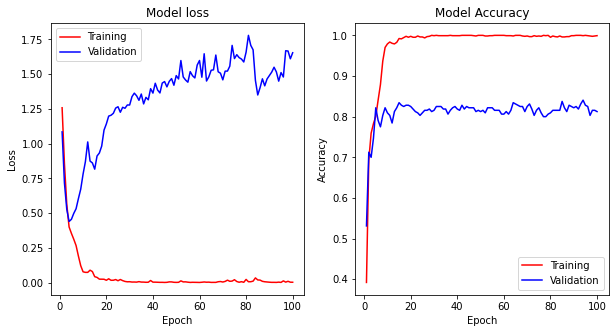

In [0]:
# Plot loss and accuracy versus training epochs
def plot_model(history):
    tr_loss = history.history['loss']
    tr_accuracy = history.history['accuracy']

    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(tr_loss)+1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss,'r')
    plt.plot(epochs, val_loss,'b')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(epochs, tr_accuracy,'r')
    plt.plot(epochs, val_accuracy,'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()
    
plot_model(history)

In [0]:
# Evaluate your model over test set
score, acc = model.evaluate(X_time_test, y_time_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.7858464813232422
Test accuracy: 0.8299999833106995


## Time-Frequency Domain Model <a id='time_freq_model'></a>

In [0]:
X, y = [], []

for audio_file in audio_files:
    
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    
    X1 = padOrClip(audio, int(audio_duration_sec*sr))
    spectrogram = np.abs(librosa.stft(X1))

    digit = audio_file.split('_')[0]
    label = audio_file.split('_')[1]
    
    X.append(spectrogram)
    y.append(label)
    
X = np.asarray(X)
y = np.asarray(y)

In [0]:
from sklearn.model_selection import train_test_split
X_freq_train, X_freq_test, y_freq_trn_label, y_freq_tst_label = train_test_split(X,y, test_size=0.2, random_state=123, stratify=y)

In [0]:
X_train = X_freq_train.reshape(-1, X_freq_train.shape[1], X_freq_train.shape[2], 1)
X_test = X_freq_test.reshape(-1, X_freq_test.shape[1], X_freq_test.shape[2], 1)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1600, 1025, 16, 1)
X_test shape: (400, 1025, 16, 1)


In [0]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(y_freq_trn_label)
y_train = out_encoder.transform(y_freq_trn_label)
y_test = out_encoder.transform(y_freq_tst_label)

print(out_encoder.classes_)

['jackson' 'nicolas' 'theo' 'yweweler']


In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (1600, 4)
y_test shape: (400, 4)


In [0]:
# Create your model
from keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', input_shape= X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1023, 14, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 511, 7, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 511, 7, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 509, 5, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 254, 2, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 254, 2, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32512)            

In [0]:
# Compile the model
model.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics= ['accuracy'])

# Fit the model
history = model.fit(X_train, y_train,
          epochs= 10,
          batch_size= 64,
          validation_split = 0.2,
          shuffle = True,
          verbose = 1)

Train on 1280 samples, validate on 320 samples
Epoch 1/10
1280/1280 [==============================] - 21s 16ms/step - loss: 1.0239 - accuracy: 0.5523 - val_loss: 0.7232 - val_accuracy: 0.9125
Epoch 2/10
1280/1280 [==============================] - 21s 16ms/step - loss: 0.4867 - accuracy: 0.8219 - val_loss: 0.3123 - val_accuracy: 0.9438
Epoch 3/10
1280/1280 [==============================] - 21s 16ms/step - loss: 0.2653 - accuracy: 0.9055 - val_loss: 0.2840 - val_accuracy: 0.9688
Epoch 4/10
1280/1280 [==============================] - 21s 16ms/step - loss: 0.1662 - accuracy: 0.9484 - val_loss: 0.1484 - val_accuracy: 0.9781
Epoch 5/10
1280/1280 [==============================] - 21s 16ms/step - loss: 0.1003 - accuracy: 0.9742 - val_loss: 0.0985 - val_accuracy: 0.9656
Epoch 6/10
1280/1280 [==============================] - 21s 17ms/step - loss: 0.1035 - accuracy: 0.9641 - val_loss: 0.0501 - val_accuracy: 0.9906
Epoch 7/10
1280/1280 [==============================] - 21s 16ms/step - loss:

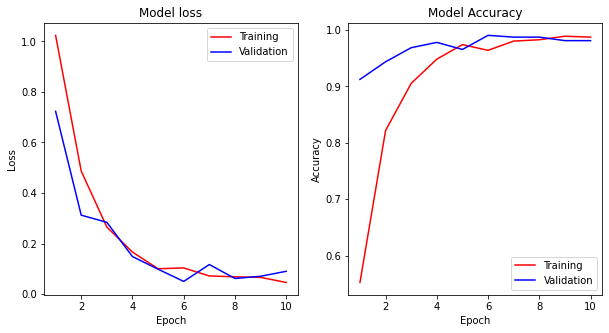

In [0]:
plot_model(history)

In [0]:
score, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.03407674044370651
Test accuracy: 0.9900000095367432
